In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import glob, os

In [19]:
def app2act_transform(lat,lon,h,theta,phi):
    """
    Input:
        lat,lon are in degrees
        h: hight of clouds in [km]
        theta and phi are in degrees
        
    """
    
    R = 6.371e6 # the radius of earth unit in meters
    a = h*1000/(np.tan((theta)*np.pi/180-np.pi/4))
    
    dx = np.sin((phi-13)*np.pi/180)*a
    dy = -np.cos((phi-13)*np.pi/180)*a
    
    lat1 = lat + 180*dx/(np.pi*R*np.cos(lon*np.pi/180))
    lon1 = lon + 180*dy/(np.pi*R)
    # lat1 = lat+dx
    # lon1 = lon+dy
    
    return lat1,lon1

def extract_tensor(sample_ds):
    # extract date to numpy arrays
    heights = sample_ds.cloud_edge_height.values 
    lats = sample_ds.latitude.values
    lons = sample_ds.longitude.values
    theta = sample_ds.theta_view.values
    phi = sample_ds.phi_view.values

    print(heights.shape)
    print(lats.shape)
    print(lons.shape)
    print(theta.shape)
    print(phi.shape)

    # from bottom to top lat, lons, heights, theta, phi
    input_tensor = np.stack([lats,lons,heights,theta,phi], axis=0)
    print('shape of input tensor: ',input_tensor.shape)
    return input_tensor

def imageTransform(image_tensor):
    
    k,m,n = image_tensor.shape
    projected_image = image_tensor.copy()
    
    for i in range(m):
        for j in range(n):
            
            lat1,lon1 = app2act_transform(image_tensor[0,i,j],image_tensor[1,i,j],image_tensor[2,i,j],image_tensor[3,i,j],image_tensor[4,i,j])#lat,lon,h,theta,phi)
            projected_image[0,i,j]= lat1
            projected_image[1,i,j] = lon1
           # print(lat1,lon1)
    return projected_image

def findaAllFiles(extn ="/*.nc"):
    """
    Note: copy all files to a folder Data
    """
    mydir = os.getcwd()
    mydir += "/Data"
    files = []
    for file in glob.glob(mydir+extn):
        files.append(file)
    
    return files



def scatterPlot(output_tensor):
    
    lons = output_tensor[1,:,:].flatten()         # 1D numpy
    lats = output_tensor[0,:,:].flatten()          # 1D numpy
    cths = output_tensor[2,:,:].flatten() # 1D numpy

    ## Then, you can e.g. simply do (nb: points plotted individually):
    plt.figure(figsize=(15,8))
    plt.scatter(lons, lats, c=cths, cmap='magma', s=0.1)

In [16]:
findaAllFiles(extn ="/*.nc") # 0 to 9 are the following filenames

['/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_03_10_B2.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_04_10_B3.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_03_10_A2.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_04_10_A1.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_05_10_B4.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_02_10_B1.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_01_10_A4.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_00_10_A5.nc',
 '/home/yz3259/Documents/Python_

In [17]:
# let us look at one of our netCDF files, as an example. Let's take the A3 one.
filenumber = int(input('Give a digit between 0 and 9 to load a file.'))
filenames =  findaAllFiles(extn ="/*.nc")
file = filenames[filenumber]
print(file)
# sample_ds = xr.open_dataset("12_02_10_A3.nc", engine="netcdf4")
sample_ds = xr.load_dataset(file, engine="netcdf4")
# NB: - open_dataset opens lazily and turns the .nc file to read-only until the corresp. ds has been .closed().
#     - load_dataset loads all the .nc contents into memory closes the .nc file immediately after.

# info for that xr.Dataset:
display(sample_ds)

Give a digit between 0 and 9 to load a file. 8


/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/12_06_10_B5.nc


<xarray.Dataset>
Dimensions:            (iy: 630, ix: 1000)
Coordinates:
  * ix                 (ix) int64 999 998 997 996 995 994 993 ... 6 5 4 3 2 1 0
  * iy                 (iy) int64 0 1 2 3 4 5 6 ... 623 624 625 626 627 628 629
Data variables:
    cloud_edge_height  (iy, ix) float32 0.0675 0.0675 0.0675 ... 0.0675 0.0675
    latitude           (iy, ix) float64 13.57 13.57 13.57 ... 14.14 14.14 14.14
    longitude          (iy, ix) float64 301.3 301.3 301.3 ... 300.4 300.4 300.4
    theta_view         (iy, ix) float32 127.0 127.0 127.0 ... 129.1 129.1 129.1
    phi_view           (iy, ix) float32 145.0 145.0 145.0 ... 147.3 147.3 147.3
    y_DALES            (iy) float32 0.0 0.1 0.2 0.3 0.4 ... 62.6 62.7 62.8 62.9
    x_DALES            (ix) float32 99.95 99.85 99.75 99.65 ... 0.25 0.15 0.05
Attributes:
    scene:     DALES_highres PAN
    timeslot:  12_06_10
    view:      B5

In [18]:
input_tensor = extract_tensor(sample_ds) # (5,630,1000) tensor: from bottom to top lat, lons, heights, theta, phi

(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
shape of input tensor:  (5, 630, 1000)


In [6]:


# projected tensor
output_tensor = imageTransform(input_tensor)


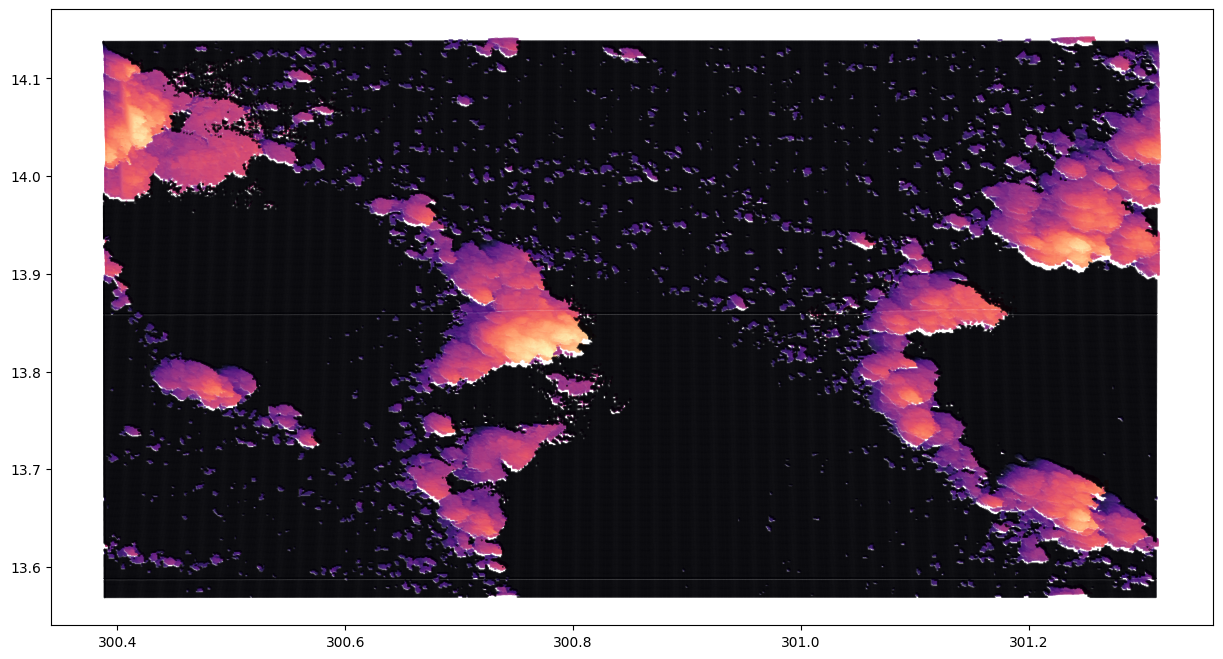

In [20]:
scatterPlot(output_tensor)


(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
shape of input tensor:  (5, 630, 1000)
[180.]


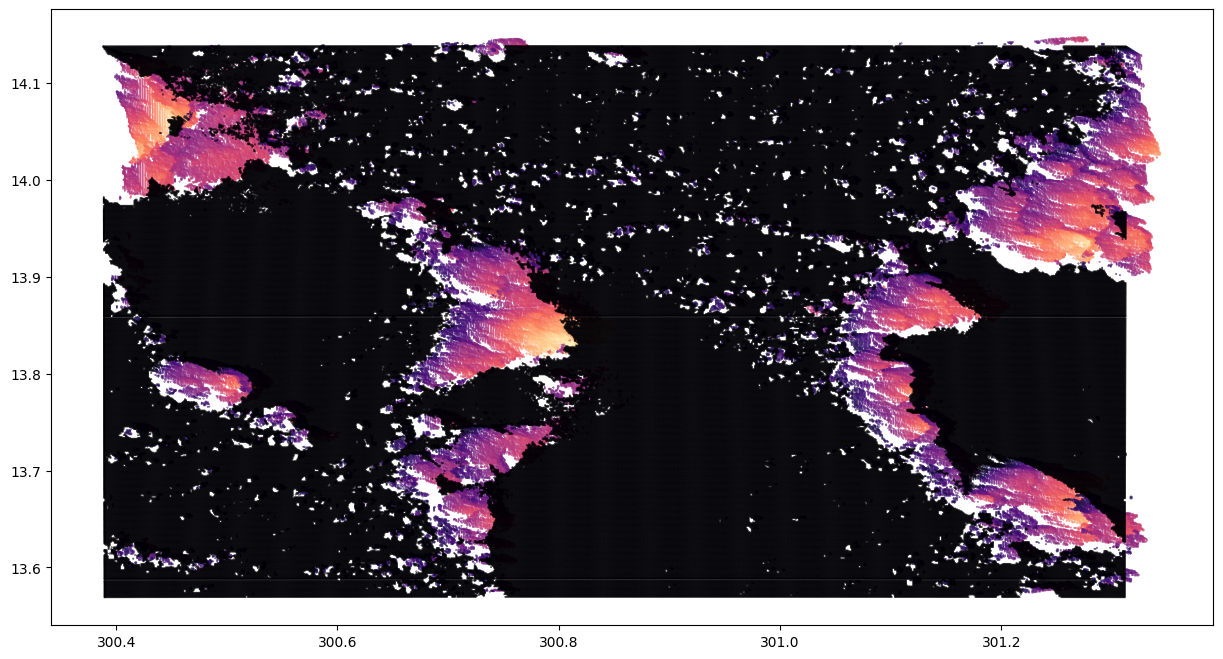

In [14]:
# Toy data
# theta is 180 deg, phi is 0 deg
# tan part does not work
input_tensor_toy = extract_tensor(sample_ds) # (5,630,1000) tensor: from bottom to top lat, lons, heights, theta, phi

input_tensor_toy[3,:,:]=180.0
input_tensor_toy[4,:,:]=0.0

output_tensor_toy = imageTransform(input_tensor_toy)
scatterPlot(output_tensor_toy)

4.477503299713135
0.06750000268220901


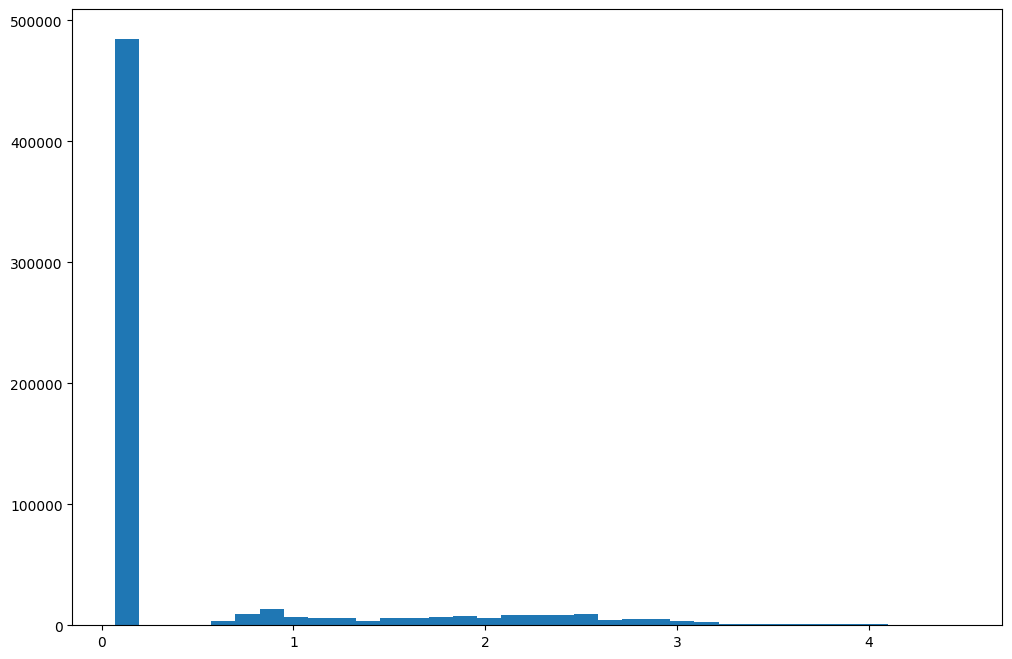

In [9]:
# histogram of the heights data
print(input_tensor[2,:,:].max())
print(input_tensor[2,:,:].min())

# this shows the range of heights

plt.figure(figsize=(12,8))
plt.hist(input_tensor[2,:,:].flatten(),bins = 35)
plt.show()
plt.close()